In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
from datetime import datetime
from datetime import timedelta
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# #identify columns in table
# #inspector=inspect(engine)
# #columns = inspector.get_columns('Measurement')
# #for c in columns:
# #    print(c['name'], c["type"])
#identify the maximum date
max_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
#convert max_date to date time format

max_date = datetime.strptime(max_date.date, '%Y-%m-%d')

# # Calculate the date 1 year ago from the last data point in the database
months_12_ago =max_date - timedelta(days = 365)

prcp=[]
dates=[]
station=[]
tobs=[]
# Perform a query to retrieve the data and precipitation scores
data=session.query(Measurement).filter(Measurement.date >= months_12_ago).all()
for row in data:
    prcp.append(row.prcp)
    dates.append(row.date)
    station.append(row.station)
    tobs.append(row.tobs)




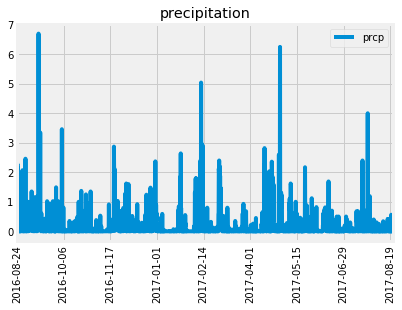

In [11]:
# Save the query results as a Pandas DataFrame and set the index to the date column
#measurement_df=pd.DataFrame({'stations':station,'Dates':dates,'prcp':prcp,'tobs':tobs}).dropna()
prcp_data = pd.DataFrame({'prcp':prcp},index=dates).dropna().sort_index()
#prcp_data=prcp_data.dropna()
# Use Pandas Plotting with Matplotlib to plot the data
prcp_data.plot(rot=90)
plt.title('precipitation')

plt.show()


![precipitation](Images/precipitation.png)

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_data.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

![describe](Images/describe.png)

In [18]:
#Station Analysis
# Design a query to show how many stations are available in this dataset?
stations_count=session.query(Station).group_by('station').count()
stations_count

9

In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations=session.query(Measurement.station, func.count(Measurement.id)).group_by(Measurement.station)\
                            .order_by(func.count(Measurement.id).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
LT_active_station=session.query(func.min(Measurement.tobs)).\
                filter(Measurement.station=='USC00519281').all()
HT_active_station=session.query(func.max(Measurement.tobs)).\
                filter(Measurement.station=='USC00519281').all()
AT_active_station=session.query(func.avg(Measurement.tobs)).\
                filter(Measurement.station=='USC00519281').all()
# highest temperature recorded, and average temperature of the most active station?
print(f"Station USC00519281 minimum temperature is {LT_active_station} ,maximum temperature is {HT_active_station}\
,average temperature is {AT_active_station}  ")


Station USC00519281 minimum temperature is [(54.0,)] ,maximum temperature is [(85.0,)],average temperature is [(71.66378066378067,)]  


In [17]:
# Choose the station with the highest number of temperature observations.
from sqlalchemy import and_
station_Mosttemp_observations=session.query(Measurement.station).group_by(Measurement.station)\
                            .order_by(func.count(Measurement.tobs).desc()).first()
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Perform a query to retrieve the data and precipitation scores
station_Mosttemp_observations_data=session.query(Measurement).\
        filter(and_(Measurement.date >= months_12_ago,\
                    Measurement.station ==station_Mosttemp_observations.station)).all()
station_Mosttemp_observations_df= pd.DataFrame([(row.id,row.station, row.date, row.prcp, row.tobs) for row in station_Mosttemp_observations_data], 
                  columns=['id', 'station', 'date', 'prcp', 'tobs'])
station_Mosttemp_observations_df


,id,station,date,prcp,tobs
0,14609,USC00519281,2016-08-24,2.15,77.0
1,14610,USC00519281,2016-08-25,0.06,80.0
2,14611,USC00519281,2016-08-26,0.01,80.0
3,14612,USC00519281,2016-08-27,0.12,75.0
4,14613,USC00519281,2016-08-28,0.60,73.0
...,...,...,...,...,...
346,14955,USC00519281,2017-08-14,0.00,77.0
347,14956,USC00519281,2017-08-15,0.32,77.0
348,14957,USC00519281,2017-08-16,0.12,76.0
349,14958,USC00519281,2017-08-17,0.01,76.0


![precipitation](Images/station-histogram.png)

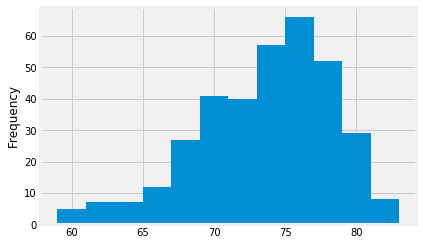

In [22]:
#Plot the results as a histogram with bins=12.
# Plot the histogram
x = station_Mosttemp_observations_df['tobs']
plt.hist(x, bins=12)
plt.ylabel('Frequency')
plt.show()

# Optional Challenge Assignment¶

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
